# Define Running Mode

- 'full_dataset = True' to use the full data set. If 'full_dataset = True', then a data set containing only data one year of the hobbies sales in TX2.  
    
- 'submit_to_kaggle = True' to submit the forecasts to Kaggle.  


In [1]:
full_dataset = True
submit_to_kaggle = False


# Import Packages

In [2]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Data Import and Preparation

In [3]:
if full_dataset:
    prefix = 'full_dataset'
else:
    prefix = 'subset'

df_merged = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_df_merged.csv')

scaling_factors_rmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/scaling_factors_rmsse.csv')

weights_wrmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/weights_for_wrmsse.csv')


In [4]:
# downcast numerical values to reduce mem usage
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to 4912.94 Mb (64.7% reduction)


# Model Training & Forecasting (LightGBM)

In [5]:
# Custom Loss & valid for asymetric rmse
def custom_mse_asymmetric_loss(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.1)
    hess = np.where(residual < 0, 2, 2 * 1.1)
    return grad, hess


def custom_rmse_asymmetric_valid(y_pred, y_true, tmp=None):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2), (residual ** 2) * 1.1)
    return "custom_mse_asymmetric_eval", np.sqrt(np.mean(loss)), False

In [6]:
# TODO: proper feature selection (e.g. random forrest)
# for now: hardcoded list of features

cat_features = [
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id',
    'year',
    'month',
    'day',
    'is_weekend',
    'wday',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_CA',
    'snap_TX',
    'snap_WI',
    'up_for_sale'
]

num_features = [
    'sell_price',
    'lag_t28',
    'rolling_kurt_t28',
    'rolling_skew_t28',
    'rolling_mean_t28',
    'rolling_std_t28',
    'price_change_t1',
    'price_change_t30',
    'rolling_price_std_t28',
]

features = cat_features + num_features

In [8]:
x_train = df_merged[df_merged['date'] <= '2016-03-27'][features]
y_train = df_merged[df_merged['date'] <= '2016-03-27']['sale']

x_val = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27'][features]
y_val = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27']['sale']

x_pred = df_merged[(df_merged['data_type'] == 'validation')][features]


print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_pred.shape)

(51954960, 27)
(51954960,)
(853720, 27)
(853720,)
(853720, 27)


In [9]:
# create datasets
train_data = lgb.Dataset(x_train, label=y_train,
                         categorical_feature=cat_features, free_raw_data=False,
                       )
validation_data = lgb.Dataset(
    x_val, label=y_val, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
)

In [10]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'seed': 10,
    'learning_rate': 0.15,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'feature_fraction ': 0.75,
}

evals_result = {}  # to record eval results for plotting

gbm = lgb.train(params, train_data, valid_sets=[train_data, validation_data],
                evals_result=evals_result, num_boost_round=1000,
                verbose_eval=25, early_stopping_rounds=20,
                fobj=custom_mse_asymmetric_loss,
                feval=custom_rmse_asymmetric_valid
               )


y_pred = gbm.predict(x_pred)

c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 2.49016	valid_1's custom_mse_asymmetric_eval: 2.24974
[50]	training's custom_mse_asymmetric_eval: 2.42272	valid_1's custom_mse_asymmetric_eval: 2.2304
[75]	training's custom_mse_asymmetric_eval: 2.38799	valid_1's custom_mse_asymmetric_eval: 2.21713
[100]	training's custom_mse_asymmetric_eval: 2.36541	valid_1's custom_mse_asymmetric_eval: 2.21312
[125]	training's custom_mse_asymmetric_eval: 2.34577	valid_1's custom_mse_asymmetric_eval: 2.20721
[150]	training's custom_mse_asymmetric_eval: 2.33188	valid_1's custom_mse_asymmetric_eval: 2.20614
[175]	training's custom_mse_asymmetric_eval: 2.31783	valid_1's custom_mse_asymmetric_eval: 2.20303
[200]	training's custom_mse_asymmetric_eval: 2.30703	valid_1's custom_mse_asymmetric_eval: 2.20244
[225]	training's custom_mse_asymmetric_eval: 2.29533	valid_1's custom_mse_asymmetric_eval: 2.20008
Early stopping, best iteration is:
[218]	training's 

# Training Analysis

Plotting metrics recorded during training...


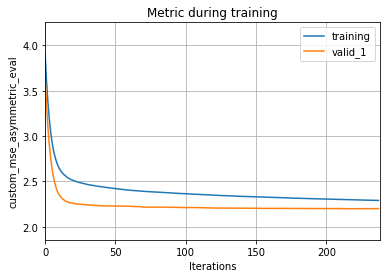

In [11]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

Plotting feature importances...


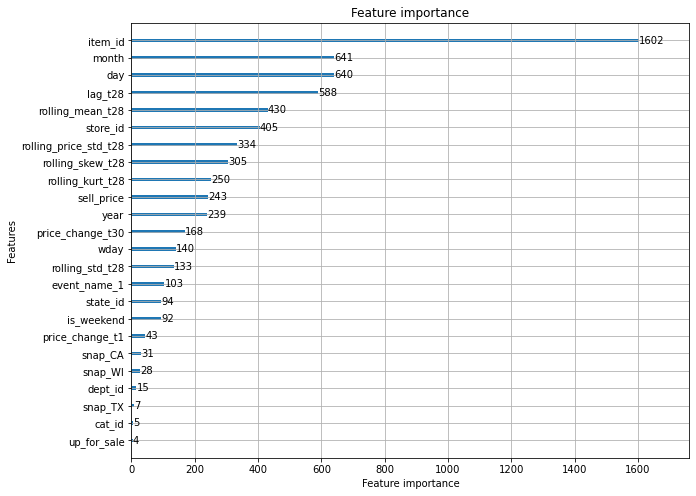

In [12]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, figsize=(10,8))
plt.show()

# Printout Forecasts

In [13]:
# map forecast values to encoded item_ids
x_val['y_pred'] = y_pred

In [14]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'store_id']].drop_duplicates()
df_results = x_val.merge(id_mapping_table,
                         on=['item_id', 'store_id'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [15]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [16]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df = submission_df.clip(lower=0) # Convert negative values to 0
submission_df.reset_index(level=0, inplace=True)
submission_df.columns = ['id'] + [f'F{di}' for di in list(range(1, 29))]
submission_df.head(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.830563,0.799211,0.799211,0.765899,1.102961,0.945084,1.041913,1.254392,0.993297,...,1.130293,1.506621,1.264888,1.426205,1.035126,1.031764,0.957695,1.030921,1.311244,1.133389
1,FOODS_1_001_CA_2_validation,0.833630,0.787387,0.773948,0.773948,0.770148,0.878588,0.925268,0.634537,0.682370,...,0.533017,0.598159,2.996143,1.052032,0.981121,0.981121,1.257591,1.044161,1.238639,1.644355
2,FOODS_1_001_CA_3_validation,1.040664,0.868879,0.939534,0.893631,0.958563,1.191297,1.235031,1.079567,1.024235,...,1.129221,1.262216,3.266864,1.629364,1.399407,1.367546,1.358199,1.356897,1.644294,1.583207
3,FOODS_1_001_CA_4_validation,0.582031,0.447420,0.447420,0.447420,0.486570,0.586340,0.617228,0.581233,0.546747,...,0.294344,0.339773,0.338874,0.365917,0.219298,0.219298,0.219298,0.271112,0.370376,0.427202
4,FOODS_1_001_TX_1_validation,0.482568,0.466355,0.466355,0.466355,0.505504,0.626626,0.683848,0.556779,0.504973,...,0.277959,0.323388,0.327566,0.227982,0.171849,0.171849,0.171849,0.190350,0.258446,0.254357
5,FOODS_1_001_TX_2_validation,0.576186,0.497074,0.497074,0.740920,0.662875,0.557832,0.564834,0.482088,0.460530,...,0.749142,0.555176,0.671677,0.492126,0.456959,0.414597,0.414597,0.426606,0.590856,0.526376
6,FOODS_1_001_TX_3_validation,0.369919,0.353706,0.353706,0.345025,0.408873,0.539812,0.587994,0.440768,0.515269,...,0.417826,0.648360,0.665976,0.426492,0.347456,0.347456,0.529790,0.464691,0.568518,0.568518
7,FOODS_1_001_WI_1_validation,0.395848,0.427202,0.393889,0.427202,0.435151,0.534921,0.583104,0.487897,0.479777,...,0.433871,0.510974,0.614422,0.393101,0.476333,0.357935,0.357935,0.395843,1.438139,0.941912
8,FOODS_1_001_WI_2_validation,0.239073,0.222861,0.222861,0.222861,0.231788,0.299884,0.631687,0.443978,0.404493,...,0.553101,0.630204,0.647821,0.466889,0.449312,0.467828,0.434516,0.440089,0.539860,0.521344
9,FOODS_1_001_WI_3_validation,0.192184,0.175971,0.237196,0.240558,0.219704,0.287800,0.345123,0.294051,0.292877,...,0.287755,0.419016,0.372152,0.259446,0.231225,0.231225,0.231225,0.249727,0.822309,0.493627


# Submit to Kaggle 

In [17]:
if submit_to_kaggle:
    # Bring data to Kaggel's required form (evaluation & validation)
    df_submission = submission_df.append(
        submission_df.replace(to_replace='validation', value='evaluation',
                              regex=True))
    filename = utils.get_m5_root_dir(
    ) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
    df_submission.to_csv(filename, index=False)
    

    # Submit via Kaggle API or with website https://www.kaggle.com/c/m5-forecasting-accuracy/submissions
    !kaggle competitions submit -c m5-forecasting-accuracy -f data/submissions/gradient_boosting_regressor_v_2_5.csv -m "asymetric loss with factor 1.1 if res > 1"
